# TP2 - Fondamentaux de l'apprentissage automatique

Executed on Colab

## Pre-execution

### Verify GPU is available

In [27]:
!nvidia-smi

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

### pip installation

In [29]:
!pip install umap-learn

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.10.* dask-cudf-cu12==24.10.* cuml-cu12==24.10.* \
    cugraph-cu12==24.10.* nx-cugraph-cu12==24.10.* cuspatial-cu12==24.10.* \
    cuproj-cu12==24.10.* cuxfilter-cu12==24.10.* cucim-cu12==24.10.* \
    pylibraft-cu12==24.10.* raft-dask-cu12==24.10.* cuvs-cu12==24.10.* \
    nx-cugraph-cu12==24.10.*

### Imports

In [30]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Only CPU
from sklearn.ensemble import RandomForestClassifier as RFC

# GPU-accelerated
from cuml.manifold import TSNE as cumlTSNE
from cuml.manifold import UMAP as cumlUMAP



### Load datas

In [31]:
print("1. Chargement des données...")
columns = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1",
    *[f"Soil_Type_{i}" for i in range(1, 40)],
    "Cover_Type"
]

print(columns)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header=None, names=columns)
data = data.sample(n=20000, random_state=42)
print(data.shape)


1. Chargement des données...
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Cover_Type']
(20000, 51)


### Split datas

In [32]:
X=data.drop('Cover_Type', axis=1)
y=data['Cover_Type']

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize datas

In [33]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fonctions

In [34]:
custom_cmap = ListedColormap(plt.cm.tab10.colors[:7])

# Fonction de visualisation
def visualize_embeddings(X, y, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, s=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [35]:
# Function to evaluate the model
def evaluate(rfc, X_test, y_test):

    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))

In [36]:
# convert second to mm:ss

def convert(seconds):
    minutes = seconds // 60
    seconds %= 60
    return "%02d:%02d" % (minutes, seconds)

## Computing

In [37]:
smote = SMOTE(random_state=42)
X_train_scaled_over, y_train_over = smote.fit_resample(X_train_scaled, y_train)

In [38]:
rus = RandomUnderSampler(random_state=42)
X_train_scaled_under, y_train_under = rus.fit_resample(X_train_scaled, y_train)

In [39]:
# Get reduced datasets
# print("2. Réduction de la dimensionnalité...")
# is_reduced = True

# if is_reduced:
#     n = 20000

#     X_train_scaled = X_train_scaled[:n]
#     y_train = y_train[:n]
#     X_train_scaled_over = X_train_scaled_over[:n]
#     y_train_over = y_train_over[:n]
#     X_train_scaled_under = X_train_scaled_under[:n]
#     y_train_under = y_train_under[:n]


### No Sampling

In [40]:
# Compute T-SNE (GPU)

time_tsne_no_sampling = time()

tsne_no_sampling = cumlTSNE(n_components=2, random_state=42)
X_tsne_no_sampling = tsne_no_sampling.fit_transform(X_train_scaled)

time_tsne_no_sampling = time() - time_tsne_no_sampling


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [15:08:46.477476] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [41]:
# Compute UMAP (GPU)

time_umap_no_sampling = time()

umap_no_sampling = cumlUMAP(n_components=2, random_state=42)
X_umap_no_sampling = umap_no_sampling.fit_transform(X_train_scaled)

time_umap_no_sampling = time() - time_umap_no_sampling

In [42]:
# Compute Random Forest Classifier

time_rfc_no_sampling = time()

rfc_no_sampling = RFC(n_estimators=100, random_state=42)
rfc_no_sampling.fit(X_train_scaled, y_train)

time_rfc_no_sampling = time() - time_rfc_no_sampling

### Under Sampling

In [43]:
# Compute T-SNE (GPU)

time_tsne_under_sampling = time()

tsne_under_sampling = cumlTSNE(n_components=2, random_state=42)
X_tsne_under_sampling = tsne_under_sampling.fit_transform(X_train_scaled_under)

time_tsne_under_sampling = time() - time_tsne_under_sampling

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


In [44]:
# Compute UMAP (GPU)

time_umap_under_sampling = time()

umap_under_sampling = cumlUMAP(n_components=2, random_state=42)
X_umap_under_sampling = umap_under_sampling.fit_transform(X_train_scaled_under)

time_umap_under_sampling = time() - time_umap_under_sampling

In [45]:
# Compute Random Forest Classifier

time_rfc_under_sampling = time()

rfc_under_sampling = RFC(n_estimators=100, random_state=42)
rfc_under_sampling.fit(X_train_scaled_under, y_train_under)

time_rfc_under_sampling = time() - time_rfc_under_sampling

### Over Sampling

In [46]:
# Compute T-SNE (GPU)

time_tsne_over_sampling = time()

tsne_over_sampling = cumlTSNE(n_components=2, random_state=42)
X_tsne_over_sampling = tsne_over_sampling.fit_transform(X_train_scaled_over)

time_tsne_over_sampling = time() - time_tsne_over_sampling

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [15:08:51.968332] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [47]:
# Compute UMAP (GPU)

time_umap_over_sampling = time()

umap_over_sampling = cumlUMAP(n_components=2, random_state=42)
X_umap_over_sampling = umap_over_sampling.fit_transform(X_train_scaled_over)

time_umap_over_sampling = time() - time_umap_over_sampling

In [48]:
# Compute Random Forest Classifier

time_rfc_over_sampling = time()

rfc_over_sampling = RFC(n_estimators=100, random_state=42)
rfc_over_sampling.fit(X_train_scaled_over, y_train_over)

time_rfc_over_sampling = time() - time_rfc_over_sampling

## Results

### Speed comparison

In [49]:
print("---- No Sampling ----")
print(f"TSNE: {convert(time_tsne_no_sampling)}")
print(f"UMAP: {convert(time_umap_no_sampling)}")
print(f"RFC: {convert(time_rfc_no_sampling)}")
print("---- Under Sampling ----")
print(f"TSNE: {convert(time_tsne_under_sampling)}")
print(f"UMAP: {convert(time_umap_under_sampling)}")
print(f"RFC: {convert(time_rfc_under_sampling)}")
print("---- Over Sampling ----")
print(f"TSNE: {convert(time_tsne_over_sampling)}")
print(f"UMAP: {convert(time_umap_over_sampling)}")
print(f"RFC: {convert(time_rfc_over_sampling)}")

---- No Sampling ----
TSNE: 00:01
UMAP: 00:00
RFC: 00:03
---- Under Sampling ----
TSNE: 00:00
UMAP: 00:00
RFC: 00:00
---- Over Sampling ----
TSNE: 00:02
UMAP: 00:00
RFC: 00:15


### No Sampling

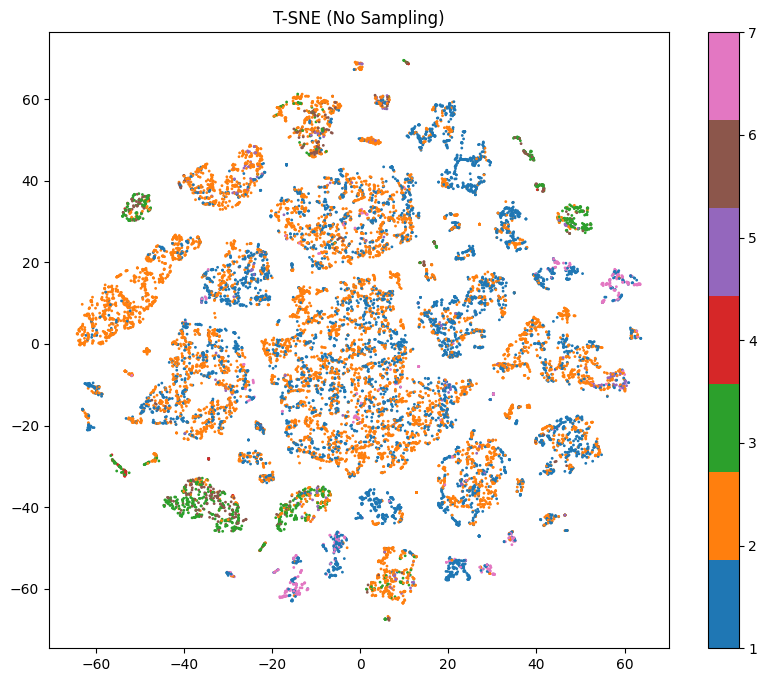

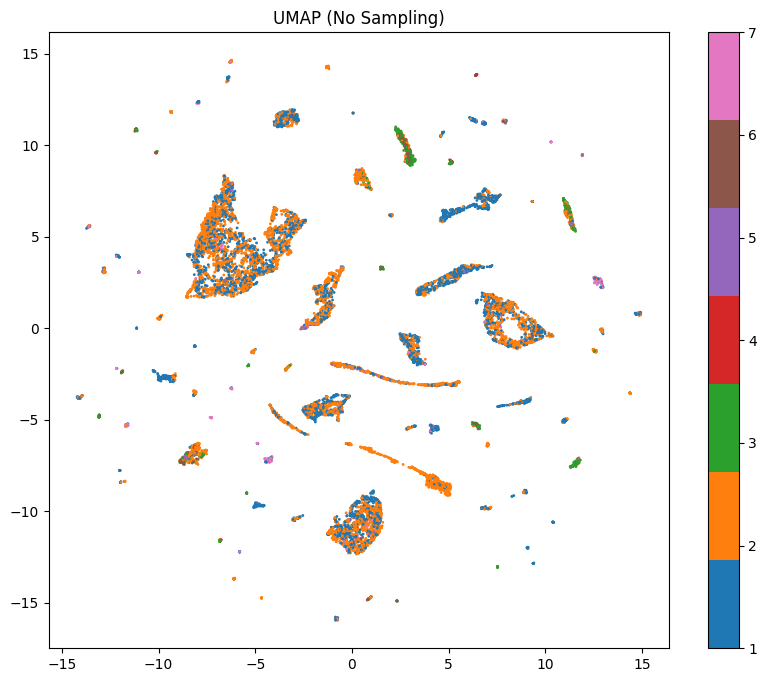

Accuracy: 0.7905
F1-Score: 0.7870

Rapport de classification:
              precision    recall  f1-score   support

           1       0.80      0.73      0.76      1459
           2       0.78      0.86      0.82      1930
           3       0.77      0.87      0.82       241
           4       1.00      0.44      0.62        18
           5       0.79      0.37      0.51        62
           6       0.84      0.52      0.64       133
           7       0.92      0.75      0.83       157

    accuracy                           0.79      4000
   macro avg       0.84      0.65      0.71      4000
weighted avg       0.79      0.79      0.79      4000



In [50]:
visualize_embeddings(X_tsne_no_sampling, y_train, "T-SNE (No Sampling)")
visualize_embeddings(X_umap_no_sampling, y_train, "UMAP (No Sampling)")
evaluate(rfc_no_sampling, X_test_scaled, y_test)

### Under Sampling

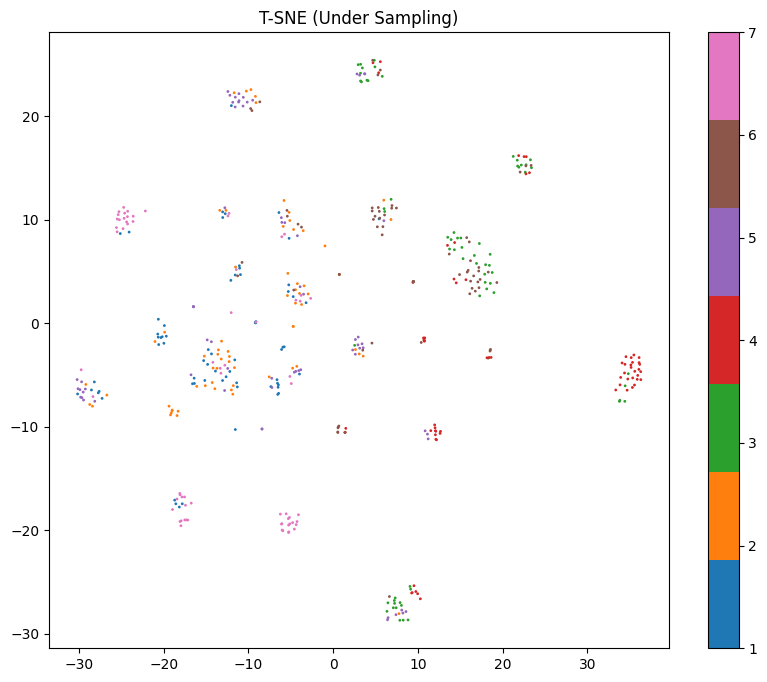

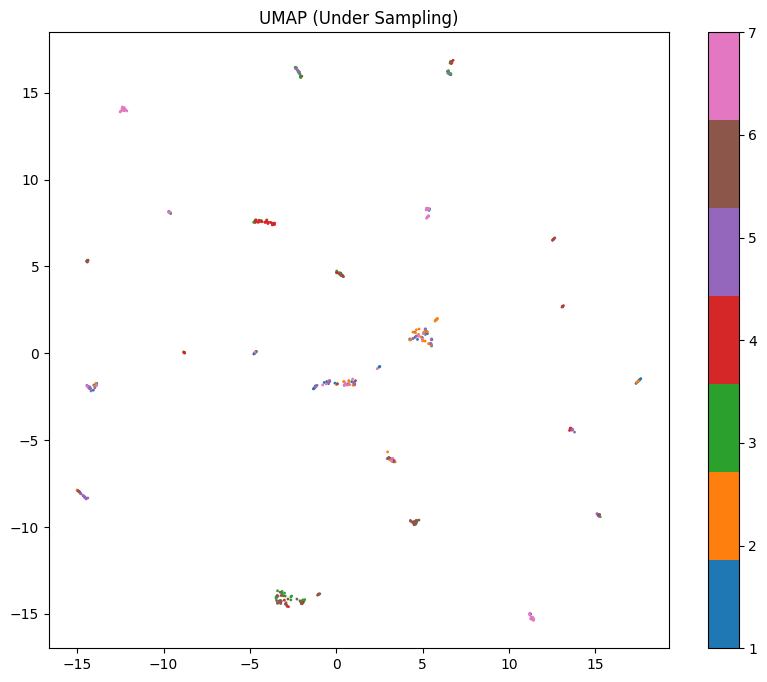

Accuracy: 0.4723
F1-Score: 0.5024

Rapport de classification:
              precision    recall  f1-score   support

           1       0.57      0.41      0.48      1459
           2       0.67      0.45      0.54      1930
           3       0.62      0.58      0.60       241
           4       0.25      1.00      0.40        18
           5       0.08      0.76      0.15        62
           6       0.26      0.60      0.37       133
           7       0.28      0.83      0.42       157

    accuracy                           0.47      4000
   macro avg       0.39      0.66      0.42      4000
weighted avg       0.59      0.47      0.50      4000



In [51]:
visualize_embeddings(X_tsne_under_sampling, y_train_under, "T-SNE (Under Sampling)")
visualize_embeddings(X_umap_under_sampling, y_train_under, "UMAP (Under Sampling)")
evaluate(rfc_under_sampling, X_test_scaled, y_test)

### Over Sampling

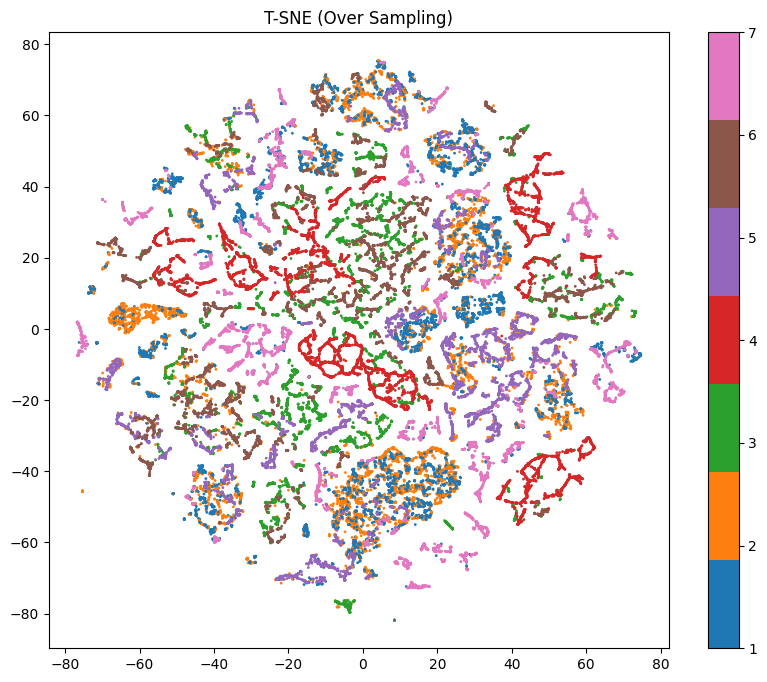

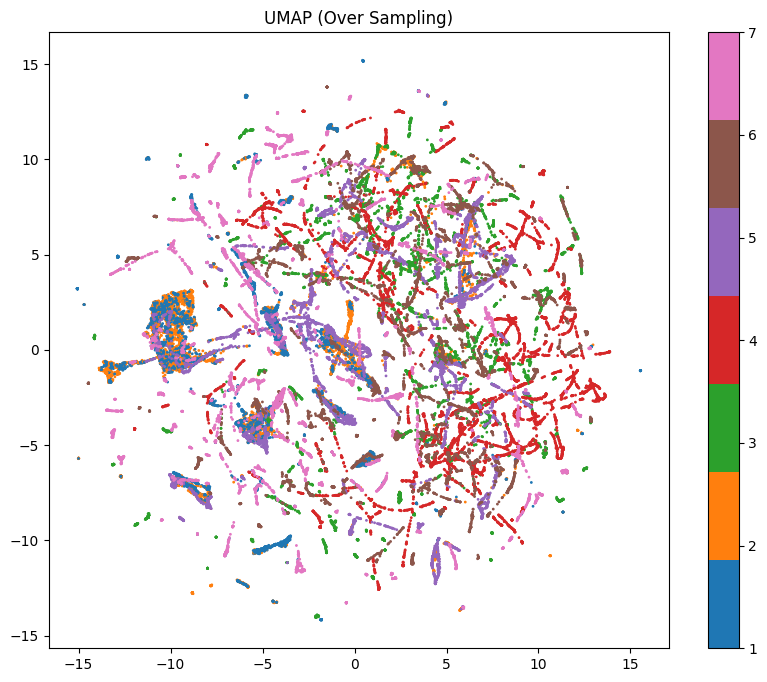

Accuracy: 0.7823
F1-Score: 0.7833

Rapport de classification:
              precision    recall  f1-score   support

           1       0.78      0.75      0.77      1459
           2       0.81      0.80      0.81      1930
           3       0.76      0.87      0.81       241
           4       0.63      0.67      0.65        18
           5       0.43      0.63      0.51        62
           6       0.65      0.73      0.69       133
           7       0.79      0.85      0.82       157

    accuracy                           0.78      4000
   macro avg       0.69      0.76      0.72      4000
weighted avg       0.79      0.78      0.78      4000



In [52]:
visualize_embeddings(X_tsne_over_sampling, y_train_over, "T-SNE (Over Sampling)")
visualize_embeddings(X_umap_over_sampling, y_train_over, "UMAP (Over Sampling)")
evaluate(rfc_over_sampling, X_test_scaled, y_test)